In [1]:
win_data = "winTogether/data.csv"
head_to_head_data = "winAgainst/data.csv"
json_path = "/home/hpham/hero.json"

In [2]:
def twoDec(x):
    return float("{0:.2f}".format(x))

In [3]:
import json

def parse_hero_id():
    with open(json_path) as json_data:
        raw_json = json.load(json_data)
        heroes = raw_json['heroes']
        return [x['id'] for x in heroes]

In [4]:
import csv

In [5]:
hero = sorted(parse_hero_id())

win_matrix = {}
head_to_head_matrix = {}

for i in range(0, len(hero)):
    if hero[i] not in win_matrix:
        win_matrix[hero[i]] = {}
    if hero[i] not in head_to_head_matrix:
        head_to_head_matrix[hero[i]] = {}
        
    for j in range(0, len(hero)):
        win_matrix[hero[i]][hero[j]] = 0
        head_to_head_matrix[hero[i]][hero[j]] = 0
        
with open(win_data, 'r') as winFile:
    data = csv.reader(winFile)
    for row in data:
#         print(row)
        newRow = [int(row[0]), int(row[1]), float(row[2]) * 100]
        win_matrix[newRow[0]][newRow[1]] = twoDec(newRow[2])
        if newRow[1] > newRow[0]:
            win_matrix[newRow[1]][newRow[0]] = twoDec(newRow[2])
            
with open(head_to_head_data, 'r') as head_to_head_csv:
    data = csv.reader(head_to_head_csv)
    for row in data:
        newRow = [int(row[0]), int(row[1]), float(row[2]) * 100]
        head_to_head_matrix[newRow[0]][newRow[1]] = twoDec(newRow[2])

In [29]:
print(head_to_head_matrix[24][33])
print(win_matrix[24][33])

49.96
51.87


In [6]:
import matplotlib.pyplot as plt

def displayWinByHero(hero_id, teammate=hero):
    win_rate = win_matrix[hero_id]
    
    value = [win_rate[x] for x in teammate]
    
    plt.figure(figsize=(20, 10), dpi=300)
    plt.bar(teammate, value, align='center')
    plt.xticks(teammate, [str(x) for x in teammate])
    plt.show()

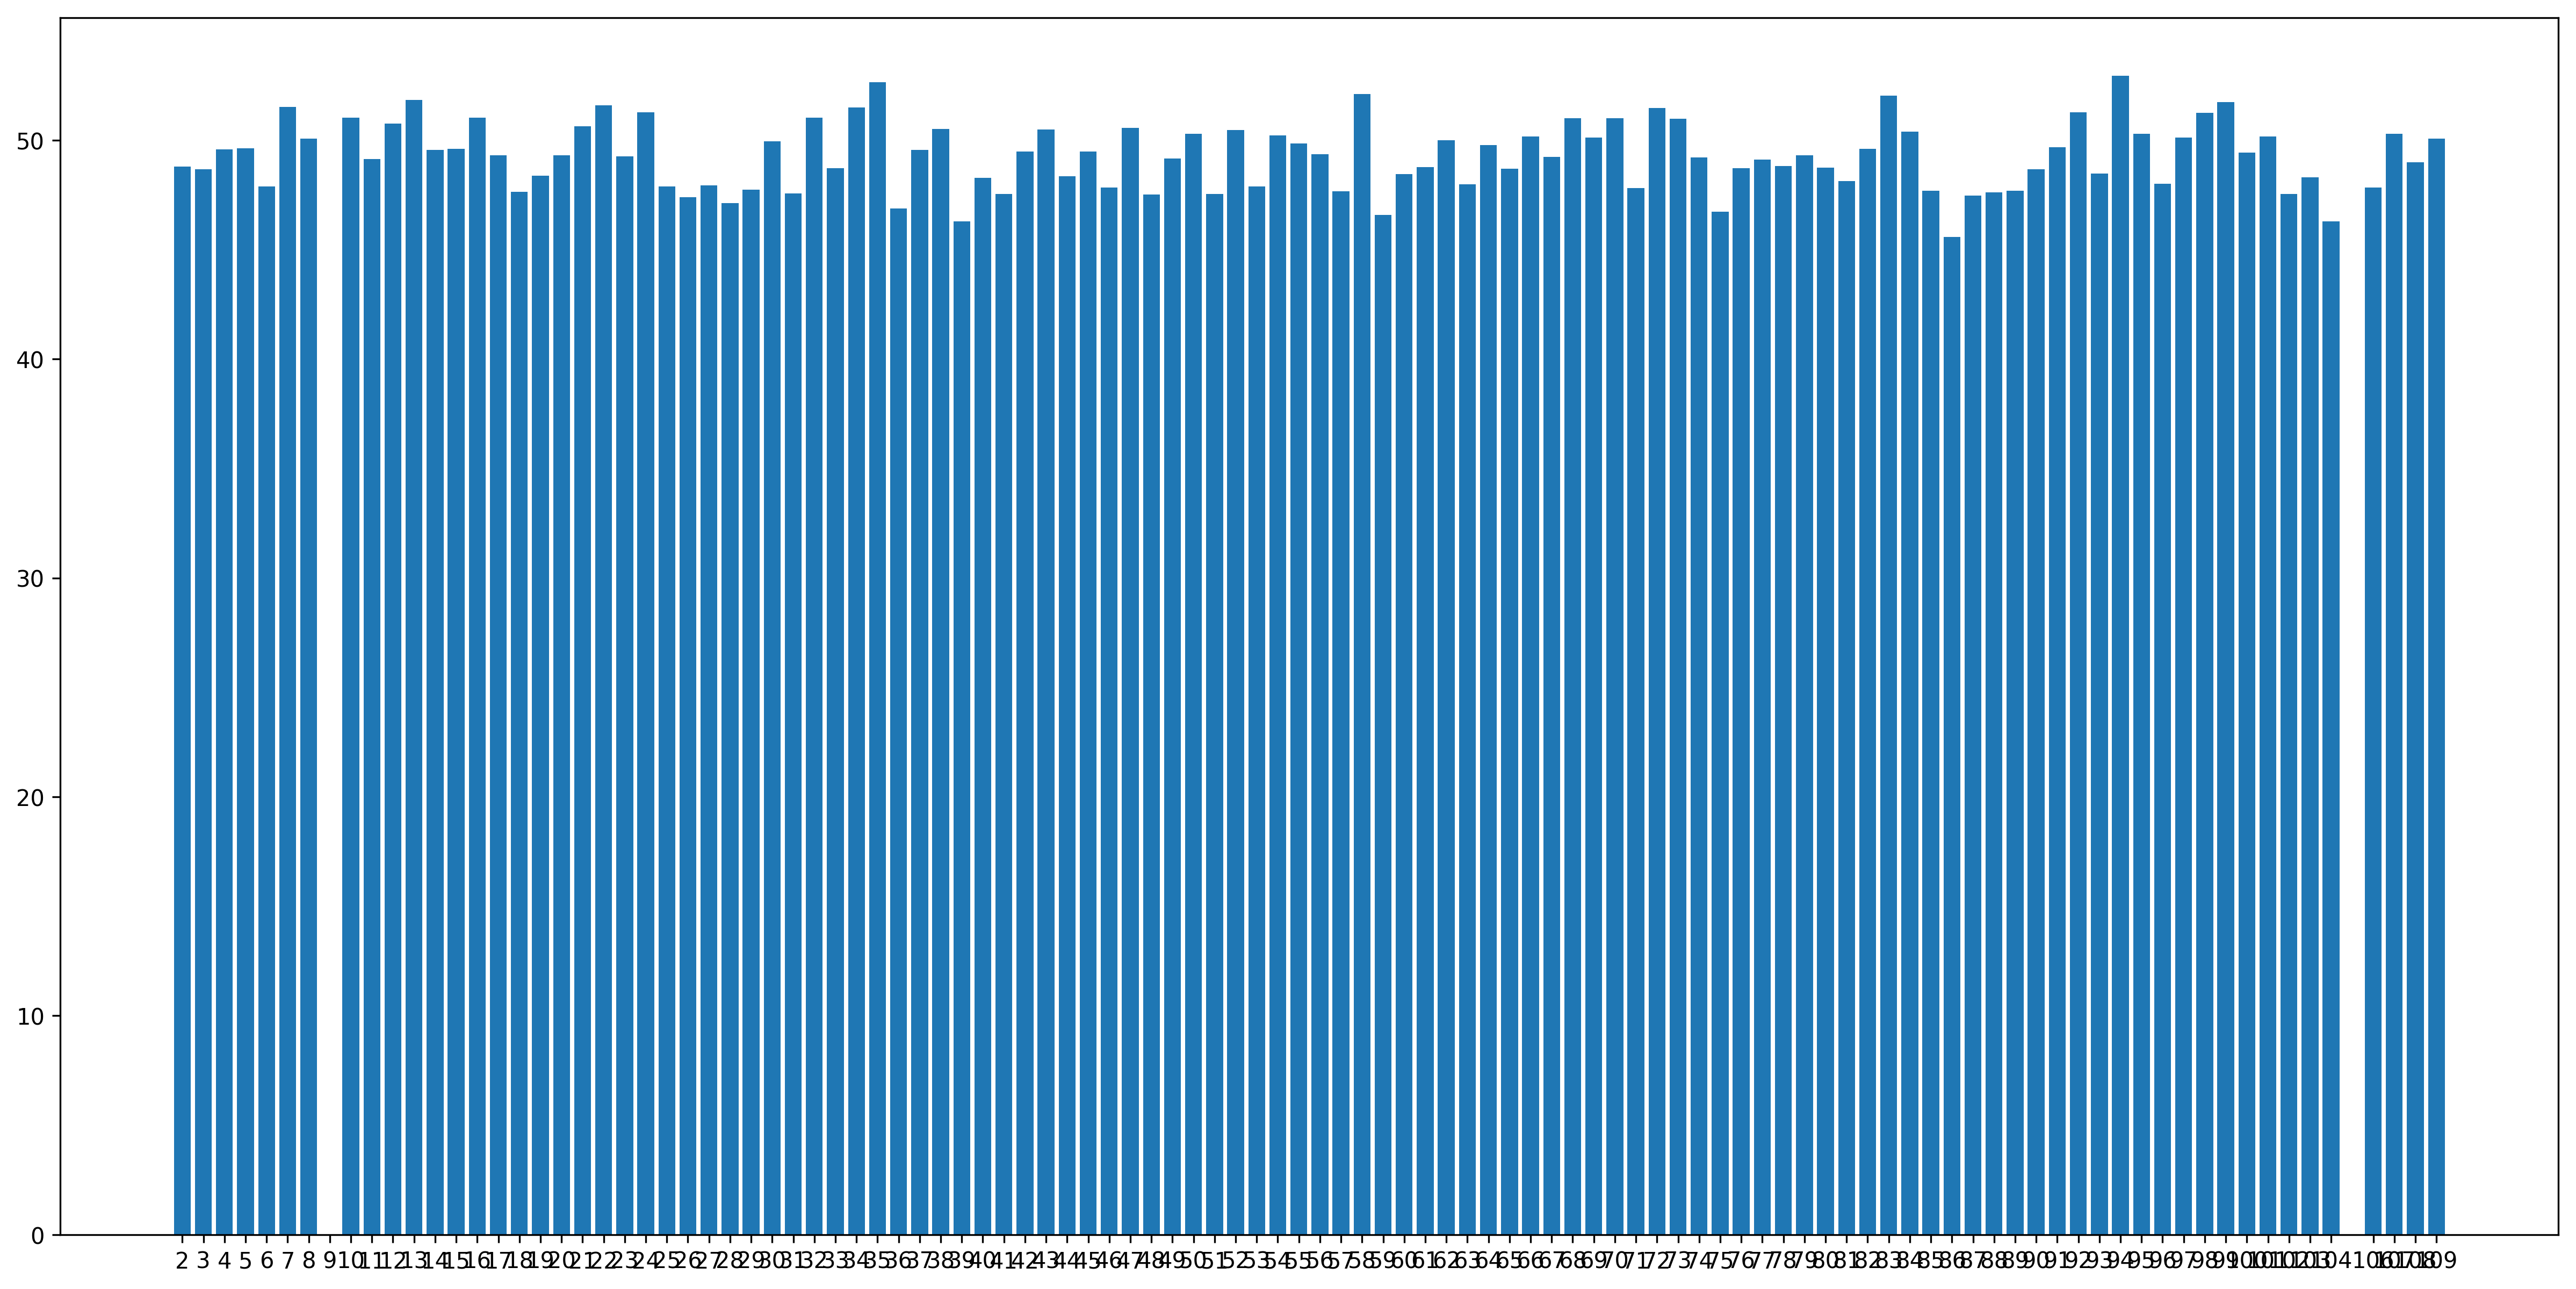

In [7]:
displayWinByHero(9)

In [8]:
def displayWinRateAgainst(hero_id, enemy=hero, isWin=True):
    record_against = head_to_head_matrix[hero_id] # {heroid: (win, lose)}
    
    value = [record_against[x] for x in enemy]
    
    plt.figure(figsize=(20, 10), dpi=300)
    plt.bar(enemy, value, align='center')
    plt.xticks(enemy, [str(x) for x in enemy])
    plt.show()

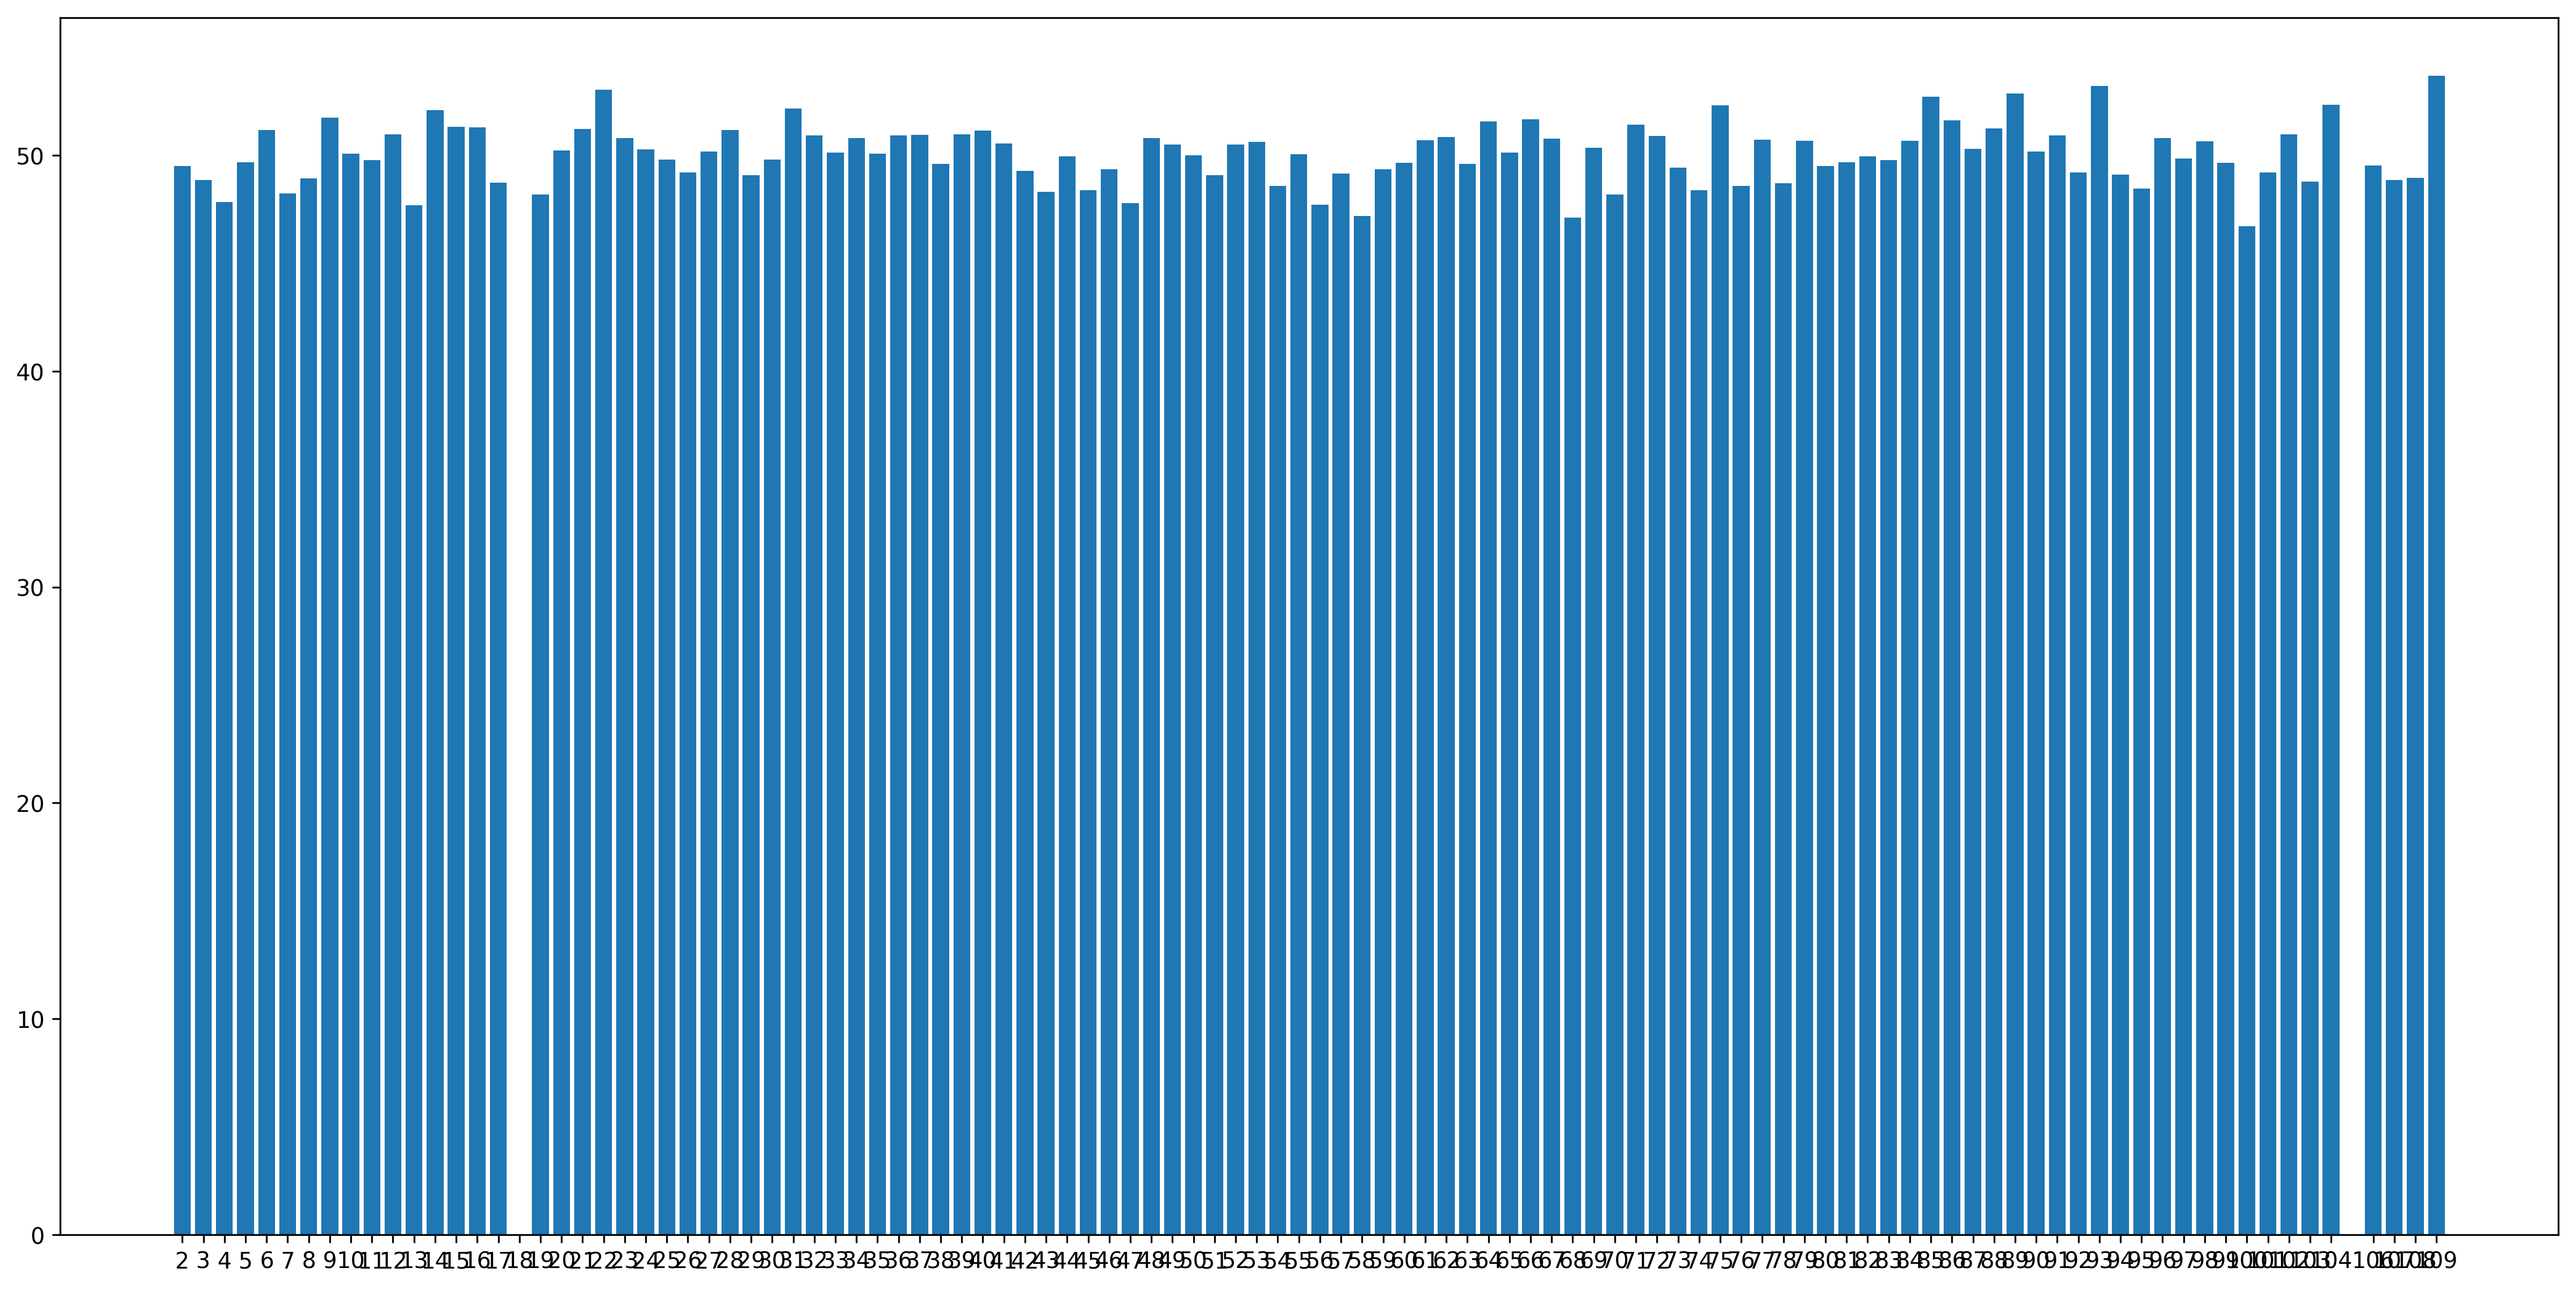

In [9]:
displayWinRateAgainst(18)

In [15]:
import pandas as pd
import numpy as np

matrix = [[ 0 for i in range(len(hero))] for j in range(len(hero))]

for i in range(len(hero)):
    for j in range(len(hero)):
        x = win_matrix[hero[i]][hero[j]]
        matrix[i][j] = x
#     print(matrix[i])
winDf = pd.DataFrame(matrix, columns=hero, index=hero)
winDf.to_csv('/home/hpham/win.csv', sep=',')

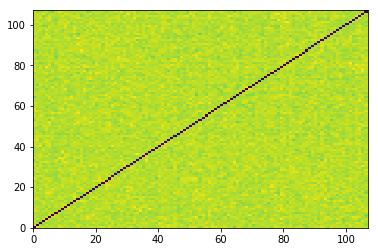

In [26]:
plt.pcolor(winDf)

In [16]:
winPredictDf = pd.read_csv(win_data, header=None,names=['user', 'item', 'rating'], index_col=None)
winPredictDf.head()

,user,item,rating
0,24,33,0.518692
1,26,35,0.500000
2,52,109,0.518240
3,36,85,0.502309
4,31,103,0.523756


In [33]:
from surprise import SVD
from surprise import Dataset, evaluate
from surprise import Reader
from surprise.model_selection import cross_validate

In [34]:
reader = Reader(rating_scale=(0, 100))

In [35]:
data = Dataset.load_from_df(winPredictDf[['user', 'item', 'rating']], reader=reader)

In [36]:
algo = SVD()
data.split(n_folds=5)
evaluate(algo, data, measures=['RMSE', 'MAE'])

/home/hpham/Documents/Project/SparkDota/Visualization/env/lib/python3.5/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/home/hpham/Documents/Project/SparkDota/Visualization/env/lib/python3.5/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.0817
MAE:  0.0644
------------
Fold 2
RMSE: 0.0753
MAE:  0.0598
------------
Fold 3
RMSE: 0.0779
MAE:  0.0618
------------
Fold 4
RMSE: 0.0766
MAE:  0.0610
------------
Fold 5
RMSE: 0.0736
MAE:  0.0590
------------
------------
Mean RMSE: 0.0770
Mean MAE : 0.0612
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.06444666253435187,
                             0.05976469867868195,
                             0.06181925202878743,
                             0.061001607621026646,
                             0.058967610030721554],
                            'rmse': [0.08171295528966702,
                             0.07528185185167528,
                             0.07793637836097393,
                             0.07663333348550666,
                             0.07361298587545091]})

In [37]:
trainset = data.build_full_trainset()
algo.train(trainset)

/home/hpham/Documents/Project/SparkDota/Visualization/env/lib/python3.5/site-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


In [38]:
testSet = trainset.build_anti_testset()

In [152]:
predictions = algo.test(testSet)

In [156]:
from collections import defaultdict

def get_top3_recommendations(predictions, topN=3):
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
    
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[::topN]
    
    return top_recs

In [157]:
get_top3_recommendations(predictions, 5)

defaultdict(list,
            {3: [(3, 0.5135604520320216)],
             4: [(4, 0.6492575316634754)],
             5: [(4, 0.5177677120497823)],
             6: [(6, 0.5717732383449192)],
             7: [(7, 0.6448116071245191)],
             8: [(7, 0.6182538534742976), (8, 0.4074948722488989)],
             9: [(9, 0.5481469727443715), (3, 0.4185859482413521)],
             10: [(8, 0.5593430805617416), (7, 0.434751814073002)],
             11: [(4, 0.6081979143989515), (8, 0.4567900932196092)],
             12: [(9, 0.6555420457844456), (11, 0.5372716622149465)],
             13: [(10, 0.5844464181598732),
              (13, 0.5120522392329656),
              (11, 0.44775889341263553)],
             14: [(5, 0.572268283287575),
              (10, 0.4795381076070817),
              (11, 0.38369900925702494)],
             15: [(13, 0.6215493997759087),
              (10, 0.5088194147751117),
              (8, 0.4422253103651139)],
             16: [(11, 0.6475715251026597),
      

In [30]:
import pandas as pd
import numpy as np

win_against = [[ 0 for i in range(len(hero))] for j in range(len(hero))]

for i in range(len(hero)):
    for j in range(len(hero)):
        x = head_to_head_matrix[hero[i]][hero[j]]
        win_against[i][j] = x
#     print(matrix[i])
winAgainstDf = pd.DataFrame(win_against, columns=hero, index=hero)
winAgainstDf.to_csv('/home/hpham/winAgainst.csv', sep=',')

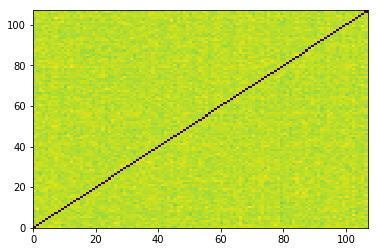

In [32]:
plt.pcolormesh(winAgainstDf)